In [138]:
import os
import urllib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import LogisticRegression
from PIL import Image
from tabulate import tabulate
import nfl_data_py as nfl

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True

In [65]:
years = range(2000, 2024)

In [66]:
for year in years:
    if not os.path.exists(f'../.cache/pbp/season={year}'):
        nfl.cache_pbp(years=[year], alt_path='../.cache/pbp', downcast=True)

df_pbp = nfl.import_pbp_data(years, cache=True, alt_path='../.cache/pbp')

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [67]:
variables = ['season','play_id','game_id','kicker_player_name', 'kicker_player_id', 
             'field_goal_attempt', 'field_goal_result', 'kick_distance']
df_fg = df_pbp[df_pbp['field_goal_attempt'] == True][variables].reset_index(drop=True)

df_fg['field_goal_made'] = df_fg['field_goal_result'].apply(lambda x: 1 if x == 'made' else 0)


df_schedules = nfl.import_schedules(years)

sched_cols = ['game_id','roof','surface','wind','temp','stadium_id','stadium']
df = df_fg.merge(df_schedules[sched_cols], on='game_id', how='left')

In [68]:
#count the number of field goals attempted and made by distance
df_binom = df.groupby('kick_distance').agg({'field_goal_attempt':'count','field_goal_made':'sum'}).reset_index()
df_binom = (df_binom.sort_values(by='kick_distance', ascending=True)
              .rename({'field_goal_attempt':'field_goal_attempts','field_goal_made':'field_goal_makes'}, axis=1))

df_binom['fg_pct'] = df_binom['field_goal_makes'] / df_binom['field_goal_attempts']
df_binom.head()

,kick_distance,field_goal_attempts,field_goal_makes,fg_pct
0,18.0,34,34,1.000000
1,19.0,239,237,0.991632
2,20.0,495,490,0.989899
3,21.0,524,516,0.984733
4,22.0,629,617,0.980922


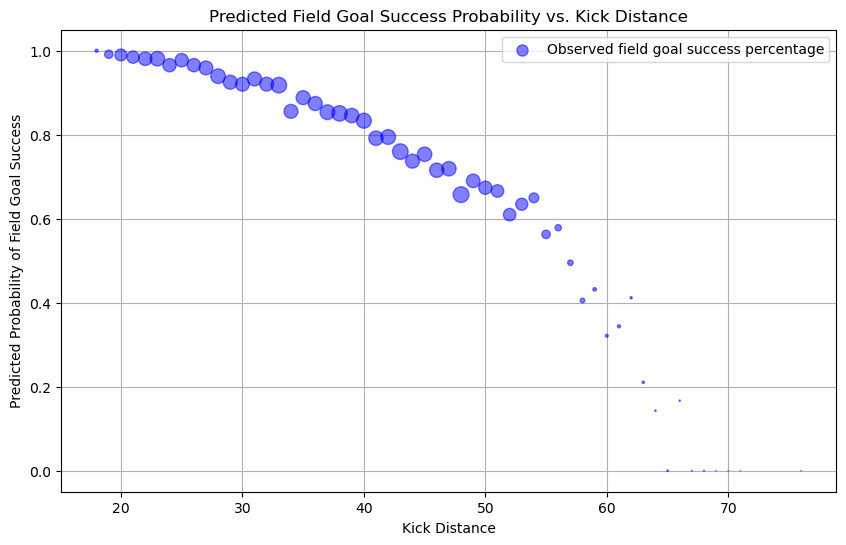

In [69]:
import matplotlib.pyplot as plt

# Extract the kick distances (as integers) and corresponding success percentages
x = df_binom['kick_distance'].values
y = df_binom['fg_pct'].values
marker_sizes = df_binom['field_goal_attempts'].values * 0.15

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the scatter plot
ax.scatter(x, y, color='blue', s=marker_sizes, label='Observed field goal success percentage', alpha=0.5)

# Set labels, title, and legend
ax.set_xlabel('Kick Distance')
ax.set_ylabel('Predicted Probability of Field Goal Success')
ax.set_title('Predicted Field Goal Success Probability vs. Kick Distance')
ax.legend()

# Send gridlines to the back
ax.set_axisbelow(True)

# Add gridlines
ax.grid()

# Show the plot
plt.show()


/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/lukeneuendorf/miniforge3/envs/4th-down/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


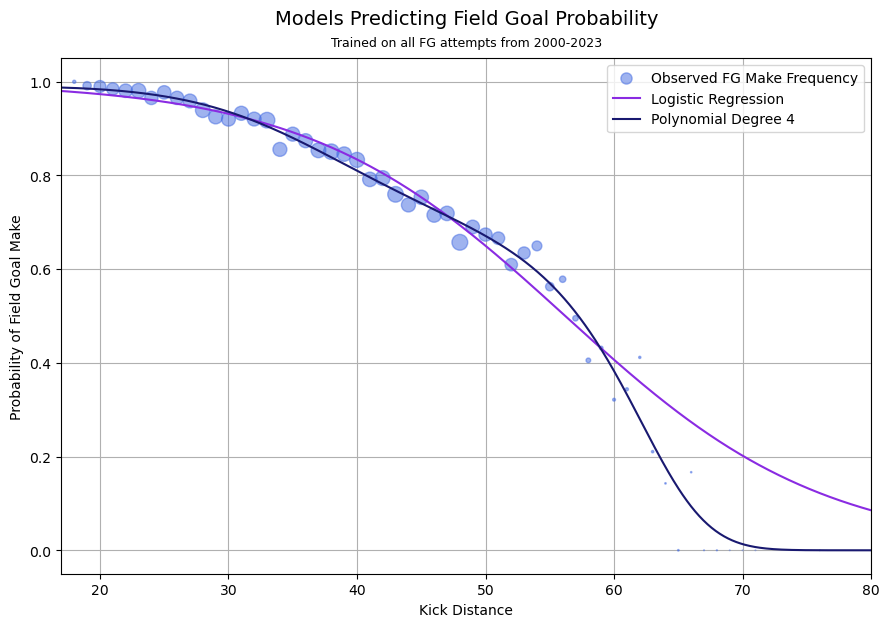

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Fit logistic regression model
X = df_fg[['kick_distance']]
y = df_fg['field_goal_made']
model = LogisticRegression()
model.fit(X, y)

# Fit polynomial logistic regression model
degree = 4
model_poly_4 = make_pipeline(PolynomialFeatures(degree), LogisticRegression())
model_poly_4.fit(X, y)

# Generate values for plotting
x_values = np.linspace(0, 80, 1000)

# Extract the kick distances (as integers) and corresponding success percentages
x = df_binom['kick_distance'].values
y = df_binom['fg_pct'].values
marker_sizes = df_binom['field_goal_attempts'].values * 0.15

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9, 6.5))

# Plot the scatter plot
ax.scatter(x, y, color='royalblue', s=marker_sizes, label='Observed FG Make Frequency', alpha=0.5)

# Plot logistic regression predictions
y_values = model.predict_proba(x_values.reshape(-1,1))[:,1]
ax.plot(x_values, y_values, color='blueviolet', label='Logistic Regression')

# Plot polynomial logistic regression predictions
y_values = model_poly_4.predict_proba(x_values.reshape(-1,1))[:,1]
ax.plot(x_values, y_values, color='midnightblue', label='Polynomial Degree 4')

# Set labels, title, and legend
ax.set_xlabel('Kick Distance')
ax.set_ylabel('Probability of Field Goal Make')
ax.set_title('Models Predicting Field Goal Probability', y=1.05, fontsize=14)

# add smaller text below title
ax.text(0.5, 1.03, 'Trained on all FG attempts from 2000-2023', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=9)

# Set legend
ax.legend()

# Send gridlines to the back
ax.set_axisbelow(True)

# Limit x axis to 17 to 80
ax.set_xlim([17, 80])

# Add gridlines
ax.grid()

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to make room for subtitle
plt.show()


In [71]:
df_fg['fg_proba'] = model_poly_4.predict_proba(df_fg[['kick_distance']])[:,1]

In [72]:
drop_cols = ['field_goal_attempt','field_goal_result']
for col in drop_cols:
    if col in df_fg.columns:
        df_fg.drop(col, axis=1, inplace=True)
df_fg.head()

,season,play_id,game_id,kicker_player_name,kicker_player_id,kick_distance,field_goal_made,fg_proba
0,2000,2771.0,2000_01_ARI_NYG,C.Blanchard,00-0001343,32.0,1,0.916383
1,2000,467.0,2000_01_BAL_PIT,M.Stover,00-0015784,23.0,1,0.976624
2,2000,1810.0,2000_01_BAL_PIT,M.Stover,00-0015784,26.0,1,0.964119
3,2000,2027.0,2000_01_BAL_PIT,M.Stover,00-0015784,33.0,1,0.905149
4,2000,2250.0,2000_01_BAL_PIT,K.Brown,00-0001980,45.0,0,0.740813


In [73]:
summary = df_fg.groupby(['kicker_player_id']).agg(
    actual_makes=('field_goal_made', 'sum'),
    total_attempts=('field_goal_made', 'count'),
    expected_makes=('fg_proba', 'sum')
).reset_index()

# Step 2: Calculate the field goal percentage and expected field goal percentage
summary['actual_fg_pct'] = summary['actual_makes'] / summary['total_attempts']
summary['expected_fg_pct'] = summary['expected_makes'] / summary['total_attempts']

# Step 3: Calculate the field goal percentage over expectation
summary['fg_pct_over_expectation'] = summary['actual_fg_pct'] - summary['expected_fg_pct']

summary.query('total_attempts > 100').sort_values(by='fg_pct_over_expectation', ascending=False).head(20)

,kicker_player_id,actual_makes,total_attempts,expected_makes,actual_fg_pct,expected_fg_pct,fg_pct_over_expectation
107,00-0029597,413,460,368.402337,0.897826,0.800875,0.096951
169,00-0036854,97,112,88.086495,0.866071,0.786487,0.079585
136,00-0033303,229,257,210.835680,0.891051,0.820372,0.070678
137,00-0033702,154,174,142.205344,0.885057,0.817272,0.067785
157,00-0035269,146,170,135.344043,0.858824,0.796141,0.062682
119,00-0031136,248,282,230.715600,0.879433,0.818140,0.061292
127,00-0032087,132,151,123.034669,0.874172,0.814799,0.059373
138,00-0033787,184,211,171.614023,0.872038,0.813337,0.058701
142,00-0034161,173,196,162.463207,0.882653,0.828894,0.053759
131,00-0032726,180,208,169.290379,0.865385,0.813896,0.051489


In [74]:
summary.sort_values('kicker_player_id').kicker_player_id.value_counts() 

kicker_player_id
00-0000108    1
00-0030626    1
00-0030896    1
00-0031092    1
00-0031093    1
00-0031112    1
00-0031136    1
00-0031203    1
00-0031385    1
00-0031492    1
00-0031543    1
00-0031656    1
00-0031718    1
00-0032065    1
00-0032087    1
00-0032569    1
00-0032584    1
00-0032669    1
00-0032726    1
00-0032835    1
00-0032870    1
00-0030850    1
00-0030390    1
00-0000282    1
00-0030332    1
00-0026318    1
00-0026375    1
00-0026858    1
00-0026968    1
00-0027119    1
00-0027191    1
00-0027405    1
00-0028058    1
00-0028660    1
00-0028787    1
00-0028872    1
00-0028907    1
00-0029318    1
00-0029421    1
00-0029576    1
00-0029597    1
00-0029621    1
00-0029822    1
00-0030098    1
00-0033102    1
00-0033138    1
00-0033303    1
00-0033702    1
00-0035849    1
00-0036162    1
00-0036168    1
00-0036436    1
00-0036459    1
00-0036469    1
00-0036515    1
00-0036703    1
00-0036816    1
00-0036854    1
00-0037224    1
00-0037606    1
00-0037645    1
00-0037

In [140]:
df_headshots = nfl.import_seasonal_rosters(years, columns=['season','player_name','player_id','headshot_url'])
df_headshots.sort_values(by='season', ascending=False, inplace=True)
df_headshots.drop_duplicates(subset='player_id', keep='first', inplace=True)
df_kickers = summary.merge(df_headshots, left_on='kicker_player_id', right_on='player_id', how='left')
df_kickers.head()

,kicker_player_id,actual_makes,total_attempts,expected_makes,actual_fg_pct,expected_fg_pct,fg_pct_over_expectation,season,player_name,player_id,headshot_url
0,00-0000108,422,516,434.959312,0.817829,0.842944,-0.025115,2013,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...
1,00-0000282,151,182,154.536630,0.829670,0.849102,-0.019432,2007,Morten Andersen,00-0000282,https://static.www.nfl.com/image/private/f_aut...
2,00-0000313,103,122,103.909426,0.844262,0.851717,-0.007454,2004,Gary Anderson,00-0000313,https://static.www.nfl.com/image/private/f_aut...
3,00-0001138,1,1,0.671025,1.000000,0.671025,0.328975,2000,Scott Bentley,00-0001138,https://static.www.nfl.com/image/private/f_aut...
4,00-0001343,16,23,19.028847,0.695652,0.827341,-0.131689,2001,Cary Blanchard,00-0001343,https://static.www.nfl.com/image/private/f_aut...


In [141]:
cols = ['player_name','headshot_url','total_attempts','actual_fg_pct','expected_fg_pct', 'fg_pct_over_expectation']
df_kickers = df_kickers[cols]

In [142]:
df_kickers.headshot_url = df_kickers.headshot_url.fillna('https://static.www.nfl.com/image/private/f_auto,q_auto/league/rtnc0qkvhmkcwwueac0o')

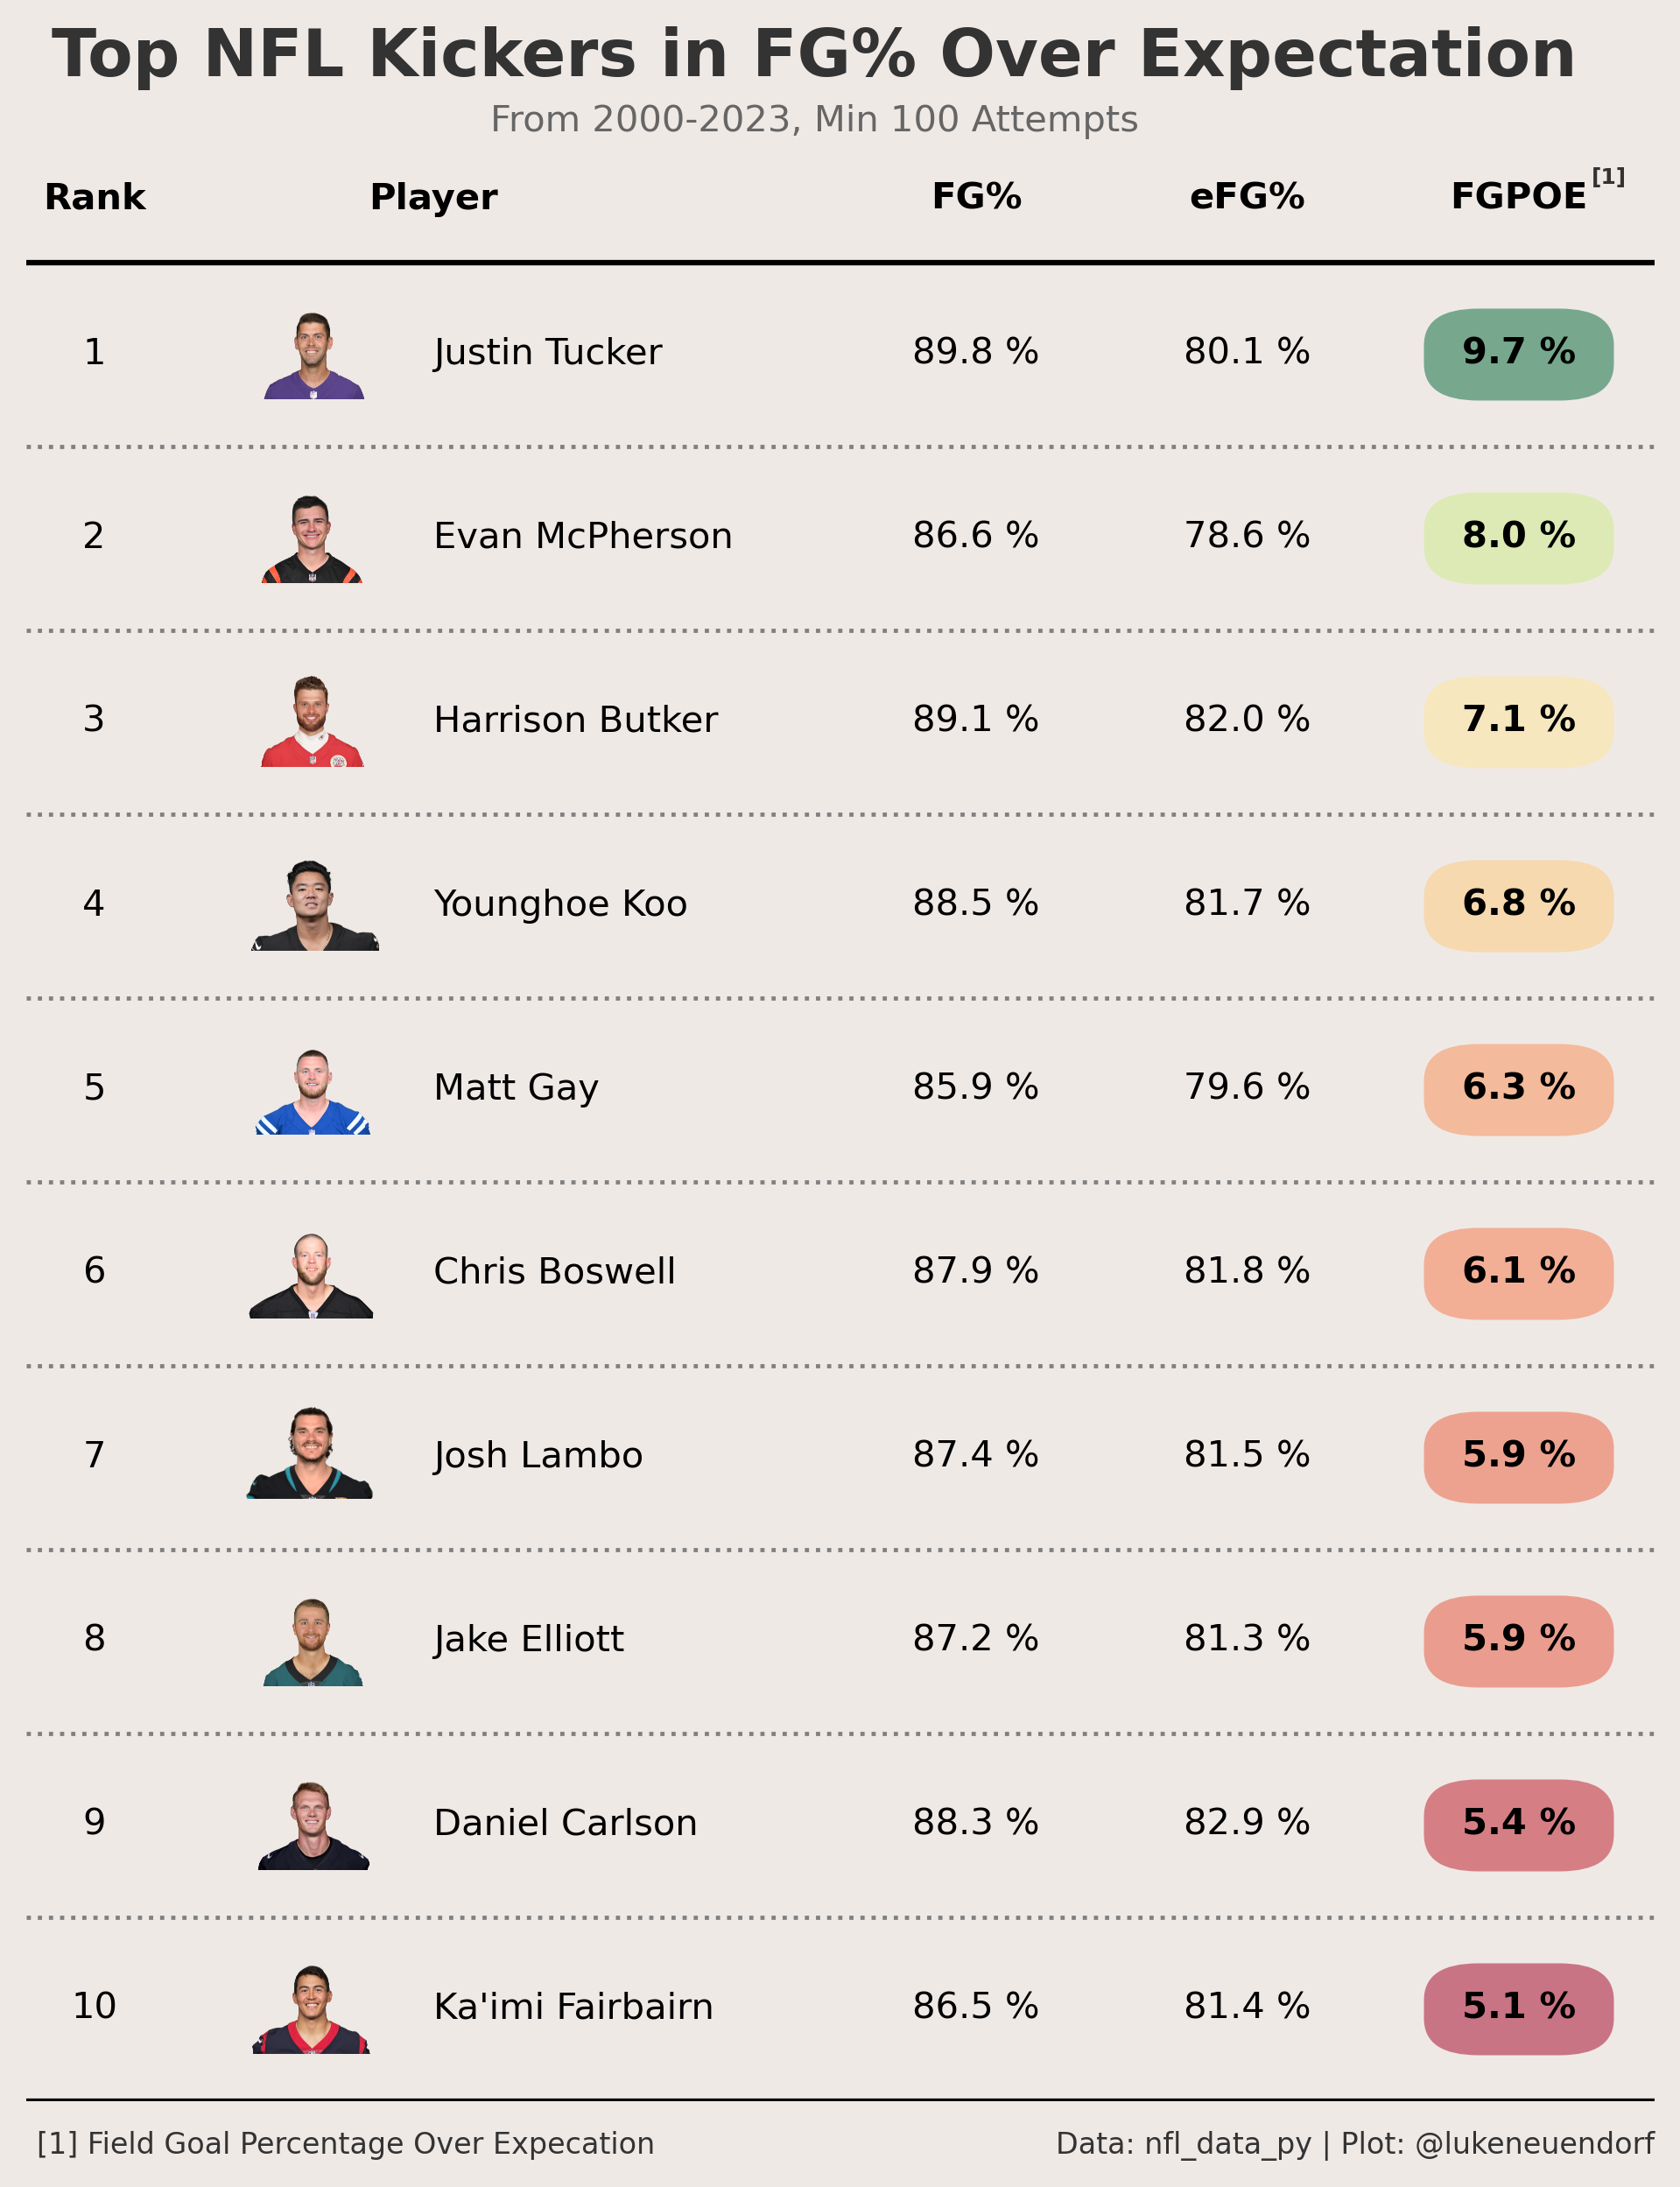

In [145]:
# Data preparation
n_attempts = 100
n_players = 10
data = (df_kickers.query('total_attempts > @n_attempts')
                  .drop('total_attempts', axis=1)
                  .sort_values('fg_pct_over_expectation', ascending=False)
                  .head(n_players)
                  .reset_index(drop=True)
                  .reset_index()
                  .sort_values('fg_pct_over_expectation', ascending=True, ignore_index=True))

data['index'] = data['index'] + 1

def ax_logo(url, ax):
    headshot = Image.open(urllib.request.urlopen(url))
    ax.imshow(headshot)
    ax.axis('off')
    return ax

# Set up figure and axis
fig = plt.figure(figsize=(8, 10), dpi=300, facecolor='#EFE9E6')
ax = plt.subplot()

ncols = 5
nrows = data.shape[0]

ax.set_xlim(0, ncols + 1)
ax.set_ylim(0, nrows + 1)

positions = [0.25, 1.5, 3.5, 4.5, 5.5]
columns = ['index', 'player_name', 'actual_fg_pct', 'expected_fg_pct', 'fg_pct_over_expectation']

# Color scaling for FGPOE
min_fgpoe = data['fg_pct_over_expectation'].min()
max_fgpoe = data['fg_pct_over_expectation'].max()

def get_color(value, min_val, max_val):
    normalized = (value - min_val) / (max_val - min_val)
    return plt.cm.RdYlGn(normalized)  # Red for low, Green for high

for i in range(nrows):
    for j, column in enumerate(columns):
        if column == 'player_name':
            ha = 'left'
        else:
            ha = 'center'
        if column == 'fg_pct_over_expectation':
            value = data[column].iloc[i]
            color = get_color(value, min_fgpoe, max_fgpoe)
            
            # Add a rounded rectangle with the color behind the text
            rect_width = 0.6  # Width of the box
            rect_height = 0.4  # Height of the box
            rect_corner_radius = 0.2  # Radius for rounded corners
            rect = patches.FancyBboxPatch(
                (positions[j] - rect_width / 2, i + 0.5 - rect_height / 2), 
                width=rect_width, 
                height=rect_height,
                boxstyle=f"round,pad=0.05,rounding_size={rect_corner_radius}",
                linewidth=0, 
                edgecolor=None, 
                facecolor=color, 
                alpha=0.5, 
                zorder=2
            )
            ax.add_patch(rect)

            text_label = f'{value * 100:,.1f} %'
            weight = 'bold'
        elif column in ['actual_fg_pct', 'expected_fg_pct']:
            text_label = f'{data[column].iloc[i] * 100:,.1f} %'
            weight = 'normal'
        else:
            text_label = f'{data[column].iloc[i]}'
            weight = 'normal'
        ax.annotate(
            xy=(positions[j], i + .5),
            text=text_label,
            ha=ha,
            va='center',
            weight=weight,
            zorder=3  # Ensure the text is above the colored box
        )

# -- Transformation functions
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
# -- Add nation axes
ax_point_1 = DC_to_NFC([2.25, 0.25])
ax_point_2 = DC_to_NFC([2.75, 0.75])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
# -- Add player images
for x in range(0, nrows):
    ax_coords = DC_to_NFC([.8, x+.25])
    flag_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_width, ax_height]
    )
    ax_logo(data['headshot_url'].iloc[x], flag_ax)

# -- Add column names
column_names = ['Rank', 'Player', 'FG%', 'eFG%', 'FGPOE']
for index, c in enumerate(column_names):
    if c == 'player_name':
        ha = 'left'
    else:
        ha = 'center'
    ax.annotate(
        xy=(positions[index], nrows + .25),
        text=column_names[index],
        ha=ha,
        va='bottom',
        weight='bold'
    )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3, marker='')

ax.set_axis_off()

# Add title and subtitle
fig.suptitle('Top NFL Kickers in FG% Over Expectation', fontsize=18, weight='bold', color='#333333', y=.9)
fig.text(0.5, 0.86, 'From 2000-2023, Min 100 Attempts', fontsize=10, ha='center', color='#666666')

# Add the [1] footnote
fig.text(0.87, .84, '[1]', fontsize=6, ha='left', color='#333333', weight='bold')

# Add footer text (e.g., Twitter handle)
fig.text(0.13, .09, '[1] Field Goal Percentage Over Expecation', fontsize=8, ha='left', color='#333333')
fig.text(0.9, .09, 'Data: nfl_data_py | Plot: @lukeneuendorf', fontsize=8, ha='right', color='#333333')

plt.show()

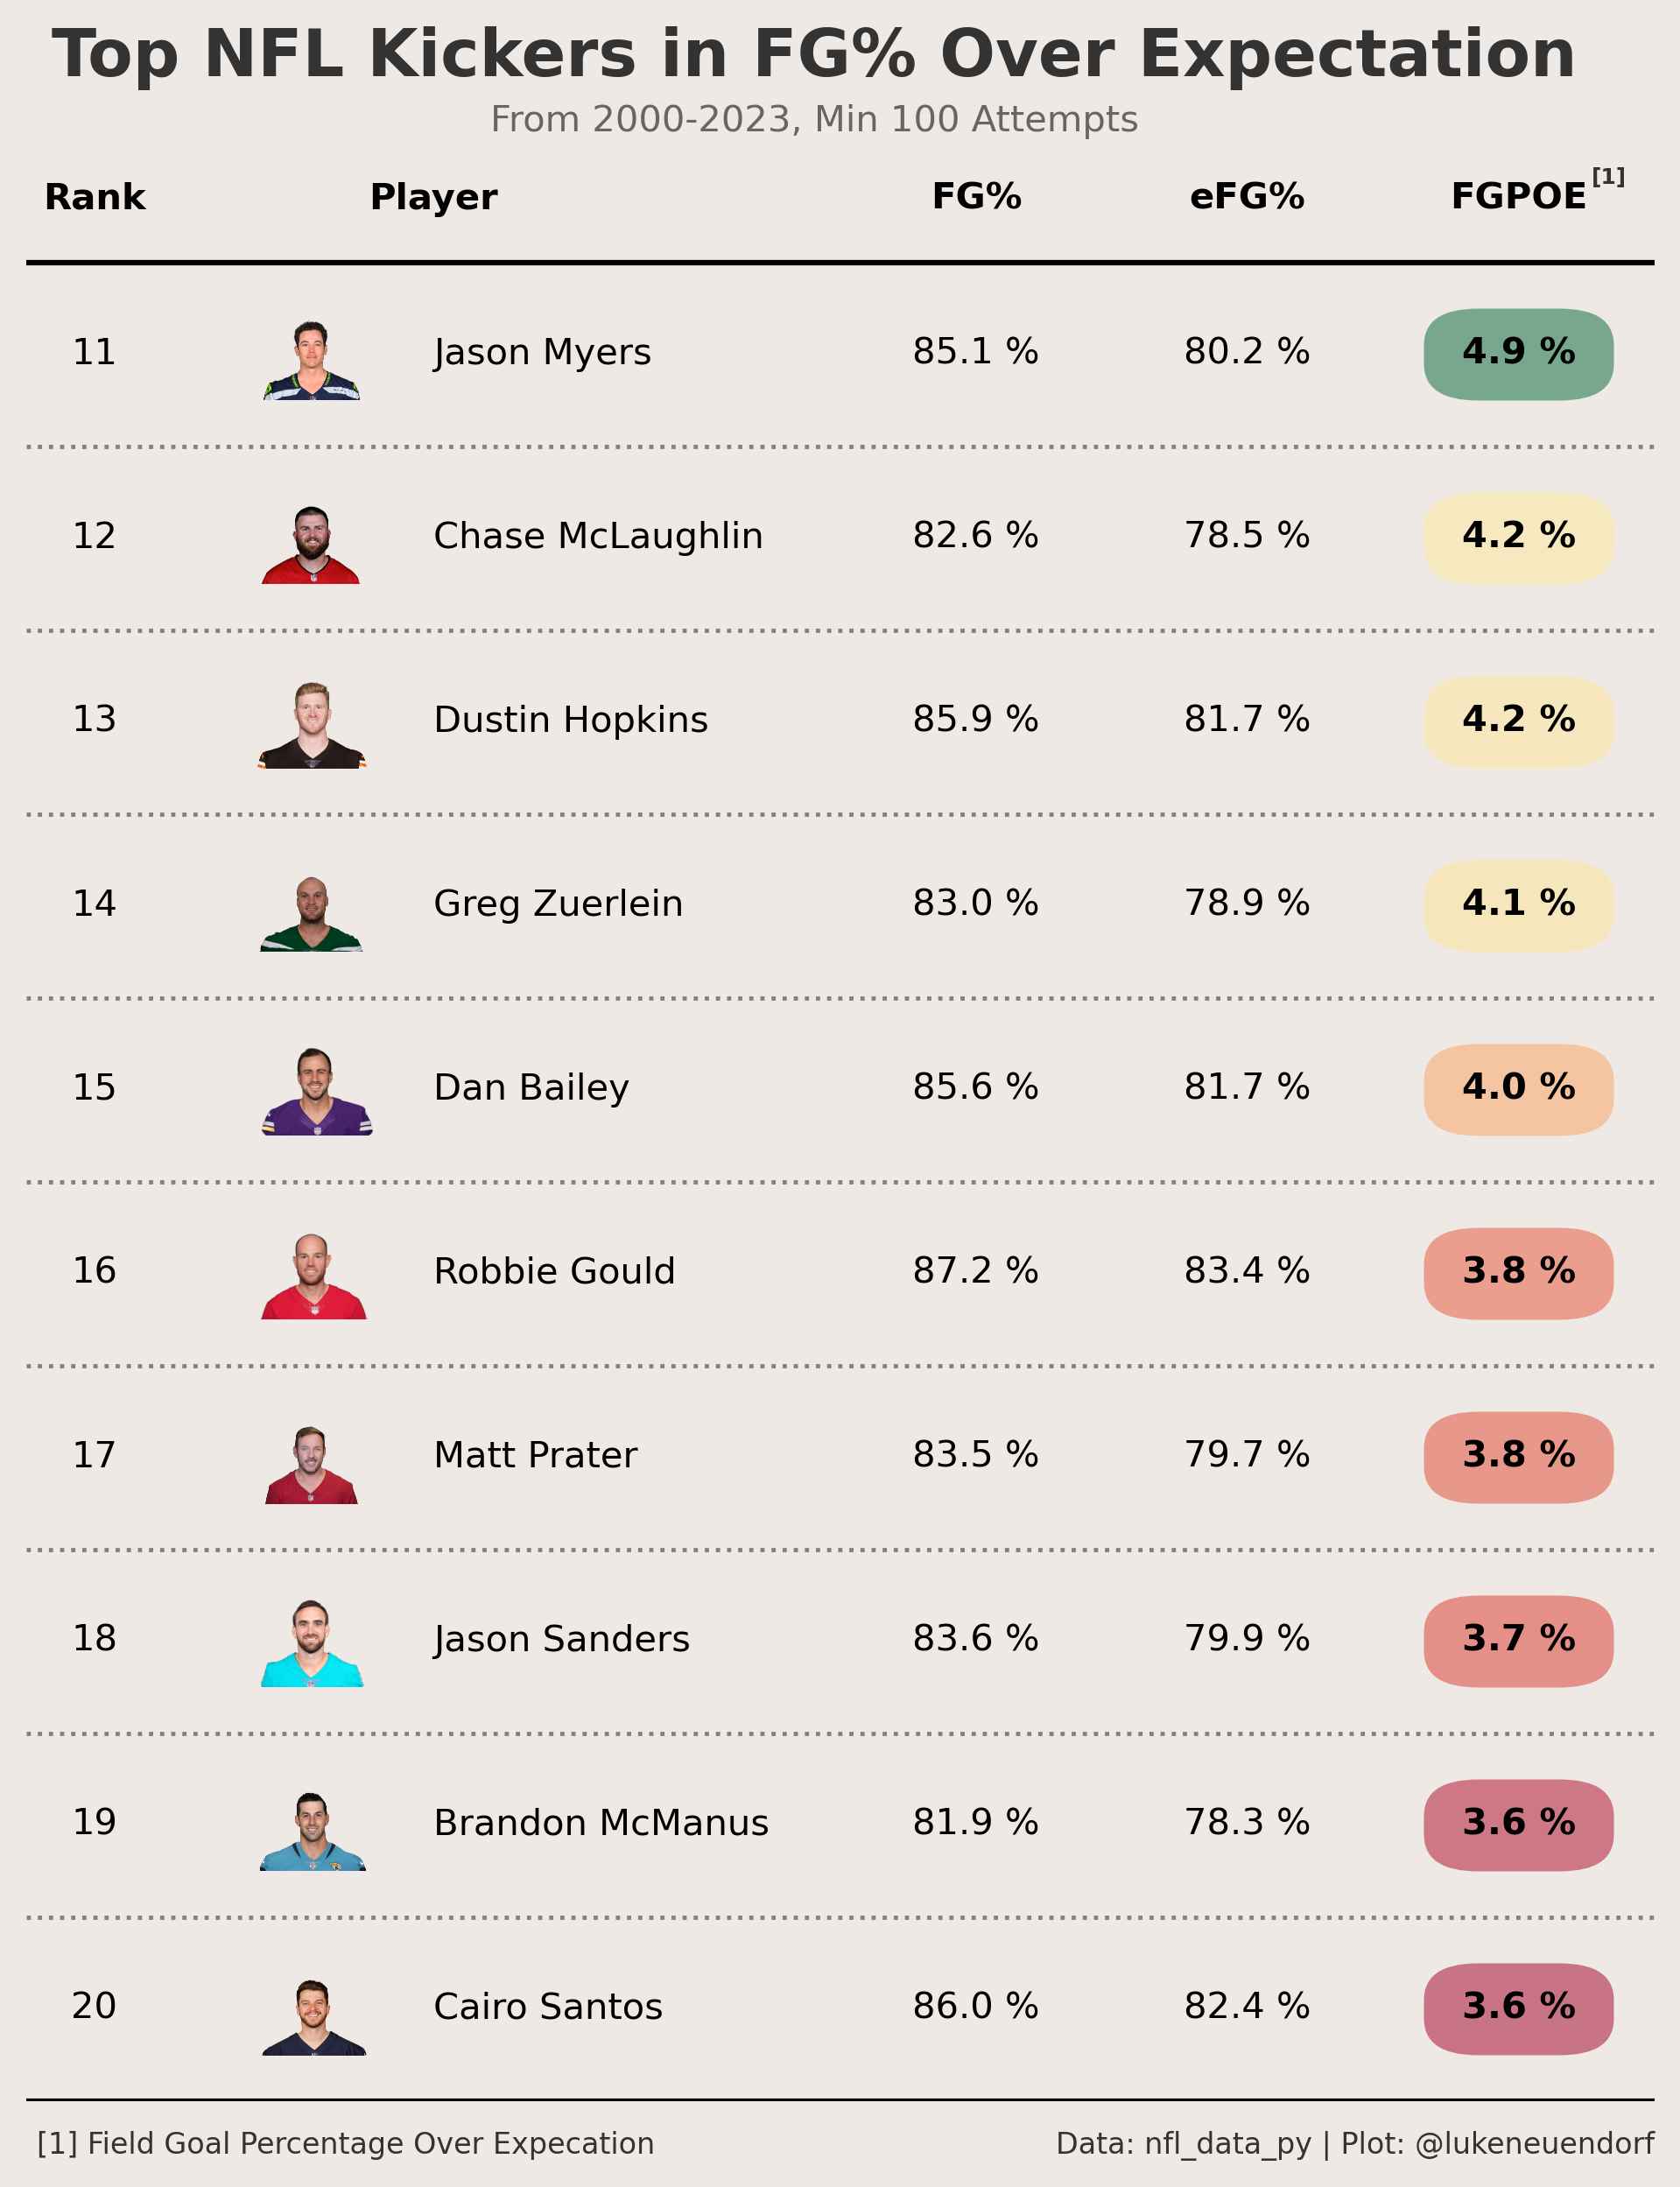

In [151]:
# Data preparation
n_attempts = 100
n_players = 10
data = (df_kickers.query('total_attempts > @n_attempts')
                  .drop('total_attempts', axis=1)
                  .sort_values('fg_pct_over_expectation', ascending=False)
                  .head(n_players + 10)
                  .reset_index(drop=True)
                  .reset_index()
                  .iloc[10:,:]  # Skip the top 10
                  .sort_values('fg_pct_over_expectation', ascending=True, ignore_index=True))

data['index'] = data['index'] + 1

def ax_logo(url, ax):
    headshot = Image.open(urllib.request.urlopen(url))
    ax.imshow(headshot)
    ax.axis('off')
    return ax

# Set up figure and axis
fig = plt.figure(figsize=(8, 10), dpi=300, facecolor='#EFE9E6')
ax = plt.subplot()

ncols = 5
nrows = data.shape[0]

ax.set_xlim(0, ncols + 1)
ax.set_ylim(0, nrows + 1)

positions = [0.25, 1.5, 3.5, 4.5, 5.5]
columns = ['index', 'player_name', 'actual_fg_pct', 'expected_fg_pct', 'fg_pct_over_expectation']

# Color scaling for FGPOE
min_fgpoe = data['fg_pct_over_expectation'].min()
max_fgpoe = data['fg_pct_over_expectation'].max()

def get_color(value, min_val, max_val):
    normalized = (value - min_val) / (max_val - min_val)
    return plt.cm.RdYlGn(normalized)  # Red for low, Green for high

for i in range(nrows):
    for j, column in enumerate(columns):
        if column == 'player_name':
            ha = 'left'
        else:
            ha = 'center'
        if column == 'fg_pct_over_expectation':
            value = data[column].iloc[i]
            color = get_color(value, min_fgpoe, max_fgpoe)
            
            # Add a rounded rectangle with the color behind the text
            rect_width = 0.6  # Width of the box
            rect_height = 0.4  # Height of the box
            rect_corner_radius = 0.2  # Radius for rounded corners
            rect = patches.FancyBboxPatch(
                (positions[j] - rect_width / 2, i + 0.5 - rect_height / 2), 
                width=rect_width, 
                height=rect_height,
                boxstyle=f"round,pad=0.05,rounding_size={rect_corner_radius}",
                linewidth=0, 
                edgecolor=None, 
                facecolor=color, 
                alpha=0.5, 
                zorder=2
            )
            ax.add_patch(rect)

            text_label = f'{value * 100:,.1f} %'
            weight = 'bold'
        elif column in ['actual_fg_pct', 'expected_fg_pct']:
            text_label = f'{data[column].iloc[i] * 100:,.1f} %'
            weight = 'normal'
        else:
            text_label = f'{data[column].iloc[i]}'
            weight = 'normal'
        ax.annotate(
            xy=(positions[j], i + .5),
            text=text_label,
            ha=ha,
            va='center',
            weight=weight,
            zorder=3  # Ensure the text is above the colored box
        )

# -- Transformation functions
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
# -- Add nation axes
ax_point_1 = DC_to_NFC([2.25, 0.25])
ax_point_2 = DC_to_NFC([2.75, 0.75])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
# -- Add player images
for x in range(0, nrows):
    ax_coords = DC_to_NFC([.8, x+.25])
    flag_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_width, ax_height]
    )
    ax_logo(data['headshot_url'].iloc[x], flag_ax)

# -- Add column names
column_names = ['Rank', 'Player', 'FG%', 'eFG%', 'FGPOE']
for index, c in enumerate(column_names):
    if c == 'player_name':
        ha = 'left'
    else:
        ha = 'center'
    ax.annotate(
        xy=(positions[index], nrows + .25),
        text=column_names[index],
        ha=ha,
        va='bottom',
        weight='bold'
    )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3, marker='')

ax.set_axis_off()

# Add title and subtitle
fig.suptitle('Top NFL Kickers in FG% Over Expectation', fontsize=18, weight='bold', color='#333333', y=.9)
fig.text(0.5, 0.86, 'From 2000-2023, Min 100 Attempts', fontsize=10, ha='center', color='#666666')

# Add the [1] footnote
fig.text(0.87, .84, '[1]', fontsize=6, ha='left', color='#333333', weight='bold')

# Add footer text (e.g., Twitter handle)
fig.text(0.13, .09, '[1] Field Goal Percentage Over Expecation', fontsize=8, ha='left', color='#333333')
fig.text(0.9, .09, 'Data: nfl_data_py | Plot: @lukeneuendorf', fontsize=8, ha='right', color='#333333')

plt.show()